# Enunciado

Suponga que su grupo de trabajo es un equipo de consultoría que ha sido contratado por Grupo Retail Hogar para diagnosticar el caso, proponer una solución e implementarla. Considere que para el Grupo el objetivo del proyecto es **definir el precio adecuado para comprar la cartera sin tener que pagar más de la cuenta.**

¿Cuál es el problema del Grupo Retail Hogar?, ¿Cuál es el problema del Retail Financiero?, ¿Cuáles son los síntomas?, ¿Qué modelo o solución de aprendizaje automático (aprendizaje supervisado, no supervisado y/o reforzado) podría contribuir a la propuesta de consultoría? ¿Qué variable(s) y/o constructo(s) dependiente(s) serían parte de su solución? ¿Qué variable(s) y/o constructo(s) independiente(s) serían parte de su solución? ¿Qué KPI comerciales y/o de riesgo serían criterios de éxito del proyecto? 

Algunas hipótesis podría resultar de las siguientes propuestas de análisis: (i) Analizar la definición de compra de cartera en lugar de lanzamiento de tarjeta de crédito al mercado?; (ii) Analizar el potencial de negocio de la compra de la cartera para Grupo Retail Hogar; (iii) Analizar el rol y valor del machine learning como parte del informe final para el Directorio. 

Después de aplicar el método del caso grupal, desarrollar exhaustivamente el alcance definido por el cliente (rúbrica del curso) y prepare una presentación con los puntos en cuestión para exponer en clase.n clase.


# Modelo de Regresión Logística

## 1. Definición de la Variable Objetivo

Asimismo, el área de riesgo de retail financiero esquematizó un árbol de decisiones con la finalidad de estimar los niveles de calificación de deuda y apetito de riesgo actual (tenencia de oferta) en cuanto al producto préstamo en efectivo y crédito electro.

Dado que el problema nos pide estimar el precio adecuado para comprar la cartera sin tener que pagar más de la cuenta. 

Para nuestra variable objetivo, usaremos la fórmula de **Recuperación Esperada** de Altman, Resti & Sironi (2005)

$R = \sum_{i=1}^{n} (C_i \times P_i)$

Donde:

- $R$: Es la recuperación esperada
- $C_i$: Monto de la deuda
- $P_i$: Es la probabilidad de recuperación de la deuda

Siendo, además, la probabilidad de recuperación de la deuda, calculada de la siguiente manera:

- $P_i = 1 - P_{i,\text{INC}}$

Donde:

- $P_{i,\text{INC}}$: Es la probabilidad de que un cliente incumpla el pago de la deuda

Por lo tanto, dado que la el monto de la deuda es una variable del dataset, lo que buscaremos estimar es <u><strong>la probabilidad de recuperación de la deuda</strong><u>

In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc # Medición del IValue
from imblearn.over_sampling import SMOTE # Balanceo de datos
from scipy.stats.mstats import winsorize # Winsorización
from scipy.stats import normaltest, kstest # Pruebas de normalidad
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor # Prueba de Multicolinealidad
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

# Modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importamos el Dataset
df_original = pd.read_excel('1.2. BBDD Grupo Retail Hogar.xlsx',sheet_name='Sheet1')

# Generamos una copia del Dataset Original
df = df_original.copy()

# Visualizar importación
df.head()

,ID,PERIODO,Generacion,SIT_LABORAL_t_6,SIT_LABORAL_t_5,SIT_LABORAL_t_4,SIT_LABORAL_t_3,SIT_LABORAL_t_2,SIT_LABORAL_t_1,SIT_LABORAL_t,...,monto_disef,desembolso_pld,desembolso_pld_monto,macrorisk_202101,macrorisk_202001,RNG_L_MAX,RNG_LINEA_PROMEDIO,SEGMENTO_THP,RNG_L_MAX_2,SEGMENTO_MERCADO
0,1,202109,4. Baby Boomers,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,...,0,0,0,1. Prospectable,1. Prospectable,5.[20k-40k],3.[<=20K],04.BBB,6.[20K-50K],P03
1,2,202109,3. Generación X,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,...,0,0,0,1. Prospectable,1. Prospectable,6.[+40k],5.[>40K],03.A,6.[20K-50K],P01
2,3,202109,3. Generación X,INDEPENDIENTE,INDEPENDIENTE,INDEPENDIENTE,INDEPENDIENTE,INDEPENDIENTE,INDEPENDIENTE,INDEPENDIENTE,...,0,0,0,1. Prospectable,1. Prospectable,6.[+40k],3.[<=20K],02.AA,7.[+50K],P02
3,4,202109,5. Silent Generation,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,...,0,0,0,1. Prospectable,1. Prospectable,5.[20k-40k],2.[<=15K],03.A,6.[20K-50K],P03
4,5,202109,3. Generación X,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,DEPENDIENTE,...,0,0,0,1. Prospectable,1. Prospectable,3.[8k-15k],2.[<=15K],05.BB,4.[8K-15K],P03


## 2. Análisis Exploratorio de Datos (EDA)

In [6]:
def grafico_barras(cols,n_cols=3):
 
    n_rows = (len(cols) + n_cols - 1) // n_cols  
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()  # Convierte la matriz de ejes en una lista
    
    for i, col in enumerate(cols):

        # Calcular porcentajes
        value_counts = df[col].fillna('Nulos').value_counts(normalize=True) * 100 
        
        colors = ['salmon' if val == 'Nulos' else 'steelblue' for val in value_counts.index]  # Color para "Nulos"
    
        bars = axes[i].bar(value_counts.index, value_counts.values, alpha=0.7, color=colors)  # Gráfico de barras
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Porcentaje (%)')
        axes[i].tick_params(axis='x', rotation=45) 
    
        # Añadir etiquetas de porcentaje en cada barra
        for bar, percentage in zip(bars, value_counts.values):
            axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.1f}%', 
                         ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Elimina los ejes vacíos si hay menos columnas de las que caben en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [7]:
def grafico_histogramas(cols, n_cols=3):
    n_rows = (len(cols) + n_cols - 1) // n_cols  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()  # Convierte la matriz de ejes en una lista

    for i, col in enumerate(cols):
        df[col].hist(ax=axes[i], bins=20, alpha=0.7, color='steelblue', edgecolor='black')  # Histograma real
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')

    # Elimina los ejes vacíos si hay menos columnas de las que caben en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [8]:
def calcular_iv(col,df=df,target='incumplio_pago',lista_cat=None,generar_col=False):

    """
    Calcula el IV de una columna.
    
    Args:
        col (str): Columna a evaluar.
        df (DataFrame): DataFrame que contiene la columna y el target.
        target (str): Nombre de la columna objetivo.
        lista_cat (dict): Opcional. Son bins personalizados que permiten haer una mejor categorización de los datos, si es que los valores por defecto no son satisfactorios

    """

    if lista_cat is None:
        bins = sc.woebin(df[[col, target]], y=target)
    else:
        bins = sc.woebin(df[[col, target]], y=target, breaks_list={col: lista_cat})
        
    print(bins[col])
    iv = bins[col]['total_iv'].iloc[0]
    print(f"\nIV de la columna {col}: {iv}")

    #if generar_col:
    #    # Usar woebin_ply para asignar los bins a una nueva columna en el DataFrame
    #    df[f'{col}_bin'] = sc.woebin_ply(bins, df[[col]])
    
    # Graficar los bins
    plt.figure(figsize=(16,6))
    sc.woebin_plot(bins[col])
    plt.show()

In [9]:
def test_esfericidad_bartlett(dataframe: pd.DataFrame, cols: list):
    
    # A) Cálculo de la prueba de Esfericidad de Bartlett
    chi_square_value, p_value = calculate_bartlett_sphericity(dataframe[cols])
    print("Bartlett’s Test:")
    print("  Chi-square:", chi_square_value, "   p-value:", p_value)

    # B) Cálculo del KMO (Kaiser-Meyer-Olkin)
    kmo_all, kmo_model = calculate_kmo(dataframe[cols])
    print("\nKMO Test:")
    print("  KMO global:", kmo_model)

    # Generalmente, valores KMO >= 0.6 se consideran aceptables para FA
    # p-value de Bartlett pequeño (ej: < 0.05) sugiere que FA podría ser adecuado.

In [10]:
def eliminar_corr_perfecta(dataframe: pd.DataFrame) -> pd.DataFrame:

    """ 
    Función para eliminar las columnas con correlación perfecta de un dataset (1.0 o -1.0)
    """

    corr_matrix = dataframe.corr().abs()

    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    corr_masked = corr_matrix.where(mask)
    
    cols_drop = [col for col in corr_masked.columns if any(corr_masked[col] == 1.0)]
    
    dataframe_limpio = dataframe.drop(columns=cols_drop)
    
    return dataframe_limpio

### 2.1. Análisis General del Dataset

In [11]:
# Tamaño del Dataset
df.shape

(12061, 488)

In [12]:
# Hallar duplicados
df.duplicated().sum()

0

In [13]:
# Detección de valores faltantes
df.isnull().sum()[df.isnull().sum() > 0]

Generacion            1936
SIT_LABORAL_t_6       1132
SIT_LABORAL_t_5       1127
SIT_LABORAL_t_4       1126
SIT_LABORAL_t_3       1126
                      ... 
RNG_L_MAX               11
RNG_LINEA_PROMEDIO      11
SEGMENTO_THP            11
RNG_L_MAX_2             11
SEGMENTO_MERCADO        11
Length: 463, dtype: int64

In [14]:
# Calcular el porcentaje de valores nulos por columna
porc_faltantes = (df.isnull().sum() / len(df)) * 100

# Filtrar solo las columnas que tienen valores nulos
porc_faltantes = porc_faltantes[porc_faltantes > 0]

porc_faltantes

Generacion            16.051737
SIT_LABORAL_t_6        9.385623
SIT_LABORAL_t_5        9.344167
SIT_LABORAL_t_4        9.335876
SIT_LABORAL_t_3        9.335876
                        ...    
RNG_L_MAX              0.091203
RNG_LINEA_PROMEDIO     0.091203
SEGMENTO_THP           0.091203
RNG_L_MAX_2            0.091203
SEGMENTO_MERCADO       0.091203
Length: 463, dtype: float64

**Conclusiones**

- El dataset general cuenta con 12061 registros y 488 columnas.
- Aquí podemos apreciar una <u><strong>alta dimensionalidad</u></strong>. Es necesario poder aplicar alguna técnica de **Reducción de Dimensionalidad**, como PCA o Análisis Factorial.
- No tenemos valores duplicados en el dataset.
- Se pueden apreciar 463 columnas con datos faltantes. La columna "Generación" cuenta con el porcentaje de faltantes más altos del dataset (aproximadamente un 16%). Se tendrá que revisar los datos por grupo para determinar las técnicas de imputación.

In [15]:
# De acuerdo al diccionario de datos, tomaremos las columnas de Deuda al ultimo mes (representados por _t)
# Tomamos en cuenta todas las deudas de Tarjeta de Crédito de los Bancos más los créditos hipotecarios y vehiculares

cols_deuda = [# Deudas por TC
              'SALDO_TC_BBVA_t', # Deuda de tarjeta de crédito BBVA
              'SALDO_TC_BCP_t', # Deuda de tarjeta de crédito BCP
              'SALDO_TC_IBK_t', # Deuda de tarjeta de crédito Scotiabank
              'SALDO_TC_SCOT_t', # Deuda de tarjeta de crédito Scotiabank

              # Deudas Hipotecarias
              'HIPOTECARIO_t', # Deuda por crédito hipotecario
              'HIPO_MIVI_t', # Deuda por crédito hipotecario MiVivienda

              # Deuda Préstamo de Libre Disponibilidad
              'PLD_t',

              # Saldos no rotativos
              'VEHICULAR_t', # Deuda por crédito Vehicular
              'MICRO_EMP_t', # Deuda de Microempresa
              'PEQ_MED_EMP_t', # Deuda de Pequeña y Mediana Empresa
              'PRES_OTROS_t'
              ]

# Sumar columnas de Deuda
df['TOTAL_DEUDA'] = df[cols_deuda].sum(axis=1)
df[['TOTAL_DEUDA']].value_counts()

TOTAL_DEUDA
0.00           2953
19.90             3
1000.00           3
44.90             3
2.21              3
               ... 
5728.02           1
5723.54           1
5715.61           1
5708.81           1
4640005.77        1
Name: count, Length: 9072, dtype: int64

#### 2.1.1. Marca Good/Bad Bank T - Incumplimento de Pago

In [16]:
# Nuestra variable independiente para medir el incumplimiento será 'marca_good_bad_bank_t'.
# Para esto, tenemos que convertir a variable numérica
df['incumplio_pago'] = np.where(df['marca_good_bad_bank_t']=='GoodBank',0,1)

df['incumplio_pago'].value_counts(normalize=True) * 100

incumplio_pago
0    91.153304
1     8.846696
Name: proportion, dtype: float64

#### 2.1.2. Macrorisk

In [17]:
# Para calcular la probabilidad de pago, utilizaremos microsegmentaciones
cols_macrorisk = ['macrorisk_202101',
                  'macrorisk_202001']

df[cols_macrorisk].head()

,macrorisk_202101,macrorisk_202001
0,1. Prospectable,1. Prospectable
1,1. Prospectable,1. Prospectable
2,1. Prospectable,1. Prospectable
3,1. Prospectable,1. Prospectable
4,1. Prospectable,1. Prospectable


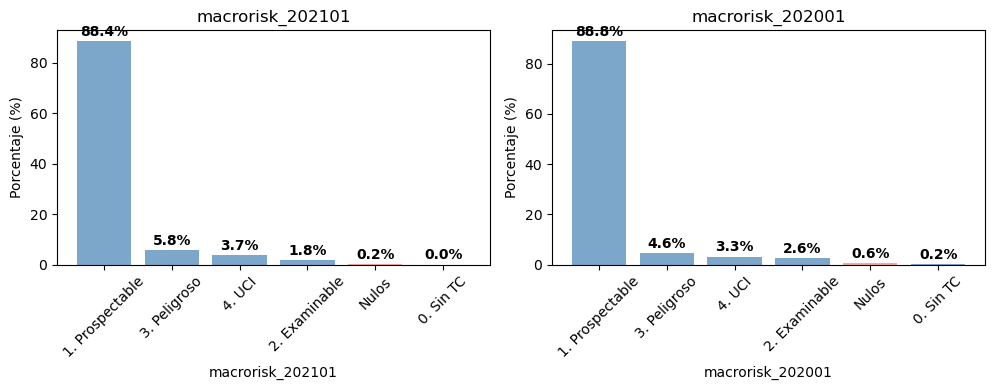

In [18]:
grafico_barras(cols_macrorisk)

Se puede apreciar que el porcentaje de nulos está entre un 0.2 y un 0.6%

In [19]:
def macrorisk_cliente(macrorisk_2020,macrorisk_2021):

    """
    Función que evalúa la matriz de riesgo del cliente en función al Segmento de Riesgo en en sistema financiero proyectado al 2020 y 2021    
    """
    if pd.isna(macrorisk_2020) or macrorisk_2020 == '0. Sin TC':
        return macrorisk_2021
    
    if macrorisk_2021 == '1. Prospectable':
        if macrorisk_2020 == '1. Prospectable':
            return macrorisk_2020
        elif macrorisk_2020 == '2. Examinable':
            return macrorisk_2020
        elif macrorisk_2020 in ('3. Peligroso','4. UCI'):
            return '3. Peligroso'
    elif macrorisk_2021 in ('2. Examinable','3. Peligroso','4. UCI'):
        return macrorisk_2021
    elif macrorisk_2021 == '0. Sin TC':
        return macrorisk_2021
    else:
        return np.nan

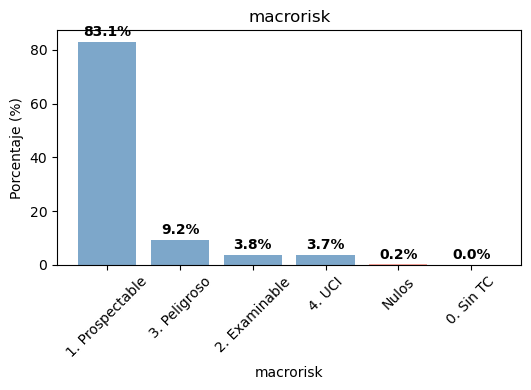

In [20]:
# Para este análisis, consideramos pertinente eliminar nulos, ya que queremos estimar basados en la clasificación de ambos años
df['macrorisk'] = df.apply(lambda row: macrorisk_cliente(row['macrorisk_202001'],row['macrorisk_202101']),axis=1)

grafico_barras(['macrorisk'])

In [21]:
# Vemos el total de datos faltantes
df[cols_macrorisk + ['macrorisk']][df['macrorisk'].isna()].shape[0]

25

In [22]:
dict_Macrorisk = {
    '0. Sin TC': 0,
    '1. Prospectable': 1,
    '2. Examinable': 2,
    '3. Peligroso': 3,
    '4. UCI': 4
}

In [23]:
df['macrorisk_num'] = df['macrorisk'].map(dict_Macrorisk)
df['macrorisk_num'].value_counts()

macrorisk_num
1.0    10019
3.0     1109
2.0      454
4.0      450
0.0        4
Name: count, dtype: int64

#### 2.1.3. Segmento Mercado

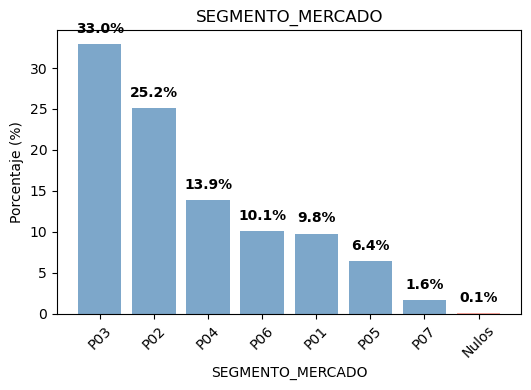

In [24]:
grafico_barras(['SEGMENTO_MERCADO'])

Debido a que la variable SEGMENTO_MERCADO sigue una escala ordinal, reemplazaremos los valores por categorías discretas

In [25]:
dict_Segm_Mercado = {
    'P01': 1,
    'P02': 2,
    'P03': 3,
    'P04': 4,
    'P05': 5,
    'P06': 6,
    'P07': 7
}

In [26]:
df['SEGMENTO_MERCADO_num'] = df['SEGMENTO_MERCADO'].map(dict_Segm_Mercado)
df['SEGMENTO_MERCADO_num'].value_counts()

SEGMENTO_MERCADO_num
3.0    3976
2.0    3034
4.0    1678
6.0    1216
1.0    1178
5.0     776
7.0     192
Name: count, dtype: int64

In [27]:
df['SEGMENTO_MERCADO_num'][df['SEGMENTO_MERCADO_num'].isna()].shape[0]

11

#### 2.1.4. Edad

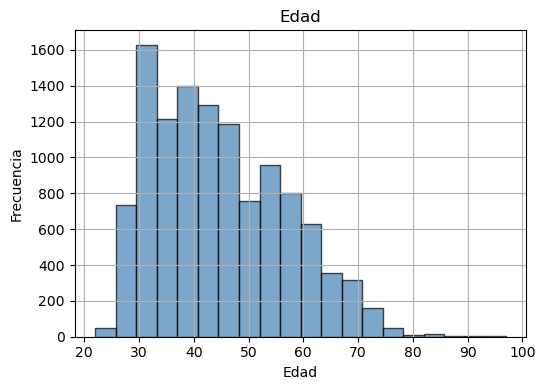

In [28]:
grafico_histogramas(['Edad'])

In [29]:
def tratar_outliers(col,df=df,coef_ri=1.5):
    
    Q1 = col.quantile(0.25) 
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    # Rango intercuartil para detectar outliers
    Lower_Whisker = Q1 - coef_ri * IQR
    Upper_Whisker = Q3 + coef_ri * IQR
    
    col = np.clip(col, Lower_Whisker, Upper_Whisker)

    return df[col]


##### Tratamiento de Outliers

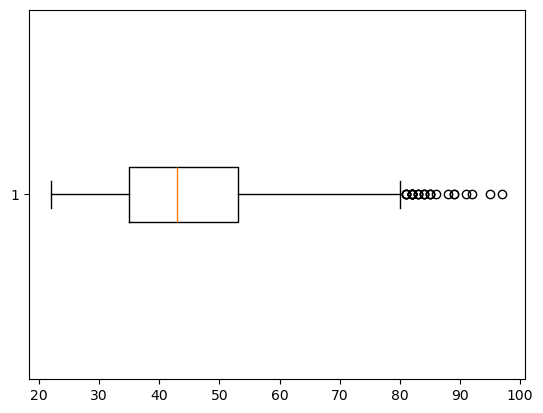

In [30]:
plt.boxplot(df['Edad'].dropna(),vert=False)
plt.show()

In [31]:
# Para winsorizar, es necesario retirar temporalmente los nulos
df['Edad_transform'] = df['Edad'].copy()

# Winsorizar
df.loc[~df['Edad_transform'].isna(), 'Edad_transform'] = winsorize(df['Edad'].dropna(), limits=[0.05, 0.05])

In [32]:
df['Edad_transform'].isnull().sum()

496

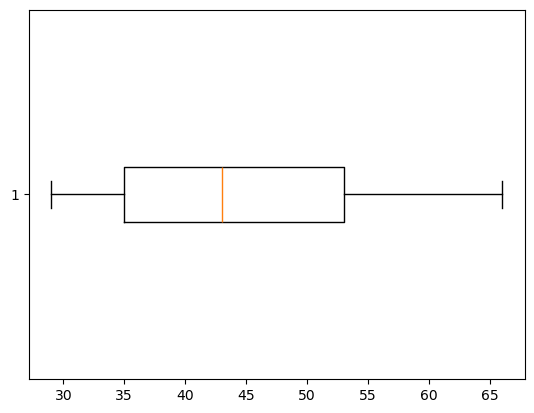

In [33]:
# Ver distribución de Edad transformada ya winsorizada
plt.boxplot(df['Edad_transform'].dropna(),vert=False)
plt.show()

##### Prueba de Normalidad

In [34]:
# Antes de imputar, verificamos si la distribución de Edad sigue una normal
# Para ello, aplicaremos dos pruebas: D'Agostino-K2 y la prueba de Kolmogorov-Smirnov

print('Pruebas de Normalidad\n')

# Test de D'Agostino (Para muestras grandes)
stat, p = normaltest(df['Edad'].dropna()) # Se elimina los valores nulos
print(f"D'Agostino Test: estadístico={stat:.4f}, p-valor={p:.4f}")

stat, p = kstest(df['Edad'].dropna(), 'norm')  # 'norm' es distribución normal
print(f"Kolmogorov-Smirnov Test: estadístico={stat:.4f}, p-valor={p:.4f}")

Pruebas de Normalidad

D'Agostino Test: estadístico=662.9446, p-valor=0.0000
Kolmogorov-Smirnov Test: estadístico=1.0000, p-valor=0.0000


In [35]:
# Debido a que ambas pruebas nos arrojaron un p-value bajo, esto significa que las distribuciones no son normales
# Para estos casos, podemos hacer una imputación por mediana
df['Edad_transform'].fillna(df['Edad_transform'].median(), inplace=True)

In [36]:
df['Edad_transform'].isnull().sum()

0

[INFO] creating woe binning ...
         variable          bin  count  count_distr  good  bad   badprob  \
0  Edad_transform  [-inf,31.0)   1155     0.095763  1073   82  0.070996   
1  Edad_transform  [31.0,36.0)   2111     0.175027  1898  213  0.100900   
2  Edad_transform  [36.0,44.0)   3220     0.266976  2949  271  0.084161   
3  Edad_transform  [44.0,53.0)   2509     0.208026  2322  187  0.074532   
4  Edad_transform  [53.0,56.0)    717     0.059448   638   79  0.110181   
5  Edad_transform   [56.0,inf)   2349     0.194760  2114  235  0.100043   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.238996  0.004959  0.024058   31.0              False  
1  0.145235  0.003919  0.024058   36.0              False  
2 -0.054604  0.000778  0.024058   44.0              False  
3 -0.186577  0.006707  0.024058   53.0              False  
4  0.243608  0.003900  0.024058   56.0              False  
5  0.135747  0.003795  0.024058    inf              False  

IV de la columna Edad

<Figure size 1600x600 with 0 Axes>

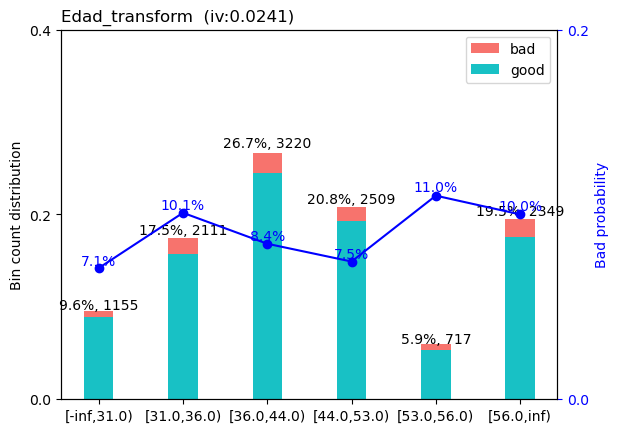

In [37]:
calcular_iv('Edad_transform')

[INFO] creating woe binning ...
         variable          bin  count  count_distr  good  bad   badprob  \
0  Edad_transform  [-inf,31.0)   1155     0.095763  1073   82  0.070996   
1  Edad_transform  [31.0,44.0)   5331     0.442003  4847  484  0.090790   
2  Edad_transform  [44.0,56.0)   3226     0.267474  2960  266  0.082455   
3  Edad_transform   [56.0,inf)   2349     0.194760  2114  235  0.100043   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.238996  0.004959  0.010651   31.0              False  
1  0.028468  0.000362  0.010651   44.0              False  
2 -0.076950  0.001534  0.010651   56.0              False  
3  0.135747  0.003795  0.010651    inf              False  

IV de la columna Edad_transform: 0.010650558777681847


<Figure size 1600x600 with 0 Axes>

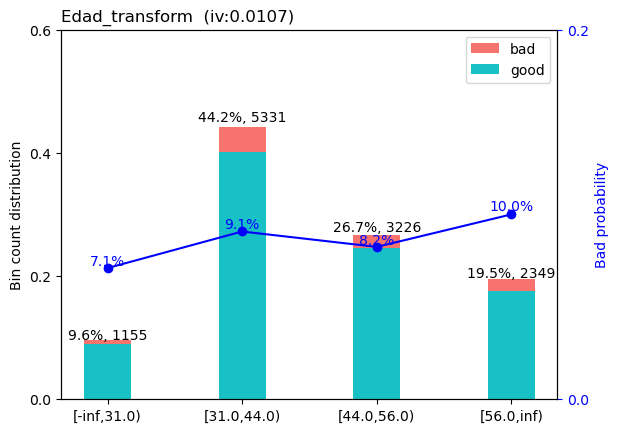

In [38]:
bins_edad = [float('-inf'),31,44,56,float('inf')]
calcular_iv('Edad_transform',lista_cat=bins_edad)

#### 2.1.5. Sexo

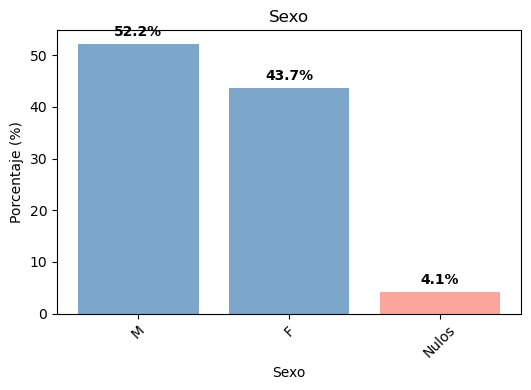

In [39]:
grafico_barras(['Sexo'])

[INFO] creating woe binning ...
  variable      bin  count  count_distr  good  bad   badprob       woe  \
0     Sexo  missing    496     0.041124   462   34  0.068548 -0.276706   
1     Sexo        F   5269     0.436863  4849  420  0.079712 -0.113774   
2     Sexo        M   6296     0.522013  5683  613  0.097363  0.105629   

     bin_iv  total_iv   breaks  is_special_values  
0  0.002811   0.01429  missing               True  
1  0.005397   0.01429        F              False  
2  0.006083   0.01429        M              False  

IV de la columna Sexo: 0.01429040438330132


<Figure size 1600x600 with 0 Axes>

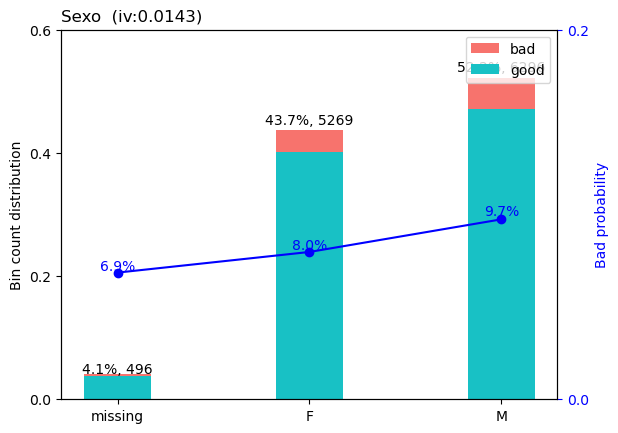

In [40]:
calcular_iv('Sexo')

##### Crear variables Dummies

In [41]:
# Crear Dummies para las variables de Sexo
df['Sexo_M'] = np.where(df['Sexo']=='M',1,0)
df['Sexo_F'] = np.where(df['Sexo']=='F',1,0)
df['Sexo_Sin_Datos'] = np.where(df['Sexo'].isna(),1,0)

#### 2.1.6. Estado Civil

In [42]:
# La columna Estado Civil tiene espacios en blanco y nulos. Para esto, agruparemos los blanco y nulos como "Sin datos" 
df['EstadoCivil_Transform'] = df['EstadoCivil'].str.strip().replace('','Sin datos').fillna('Sin datos')

In [43]:
df['EstadoCivil_Transform'].value_counts()

EstadoCivil_Transform
SOLTERO       6210
CASADO        4381
Sin datos      960
DIVORCIADO     409
VIUDO          101
Name: count, dtype: int64

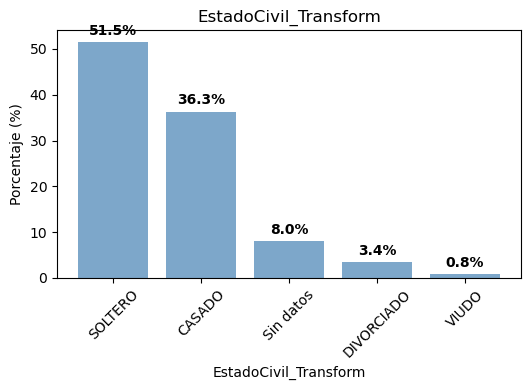

In [44]:
grafico_barras(['EstadoCivil_Transform'])

[INFO] creating woe binning ...
                variable                   bin  count  count_distr  good  bad  \
0  EstadoCivil_Transform  DIVORCIADO%,%SOLTERO   6619     0.548794  6051  568   
1  EstadoCivil_Transform             Sin datos    960     0.079595   876   84   
2  EstadoCivil_Transform        CASADO%,%VIUDO   4482     0.371611  4067  415   

    badprob       woe    bin_iv  total_iv                breaks  \
0  0.085814 -0.033359  0.000602  0.001567  DIVORCIADO%,%SOLTERO   
1  0.087500 -0.012051  0.000012  0.001567             Sin datos   
2  0.092593  0.050116  0.000953  0.001567        CASADO%,%VIUDO   

   is_special_values  
0              False  
1              False  
2              False  

IV de la columna EstadoCivil_Transform: 0.0015666820452780658


<Figure size 1600x600 with 0 Axes>

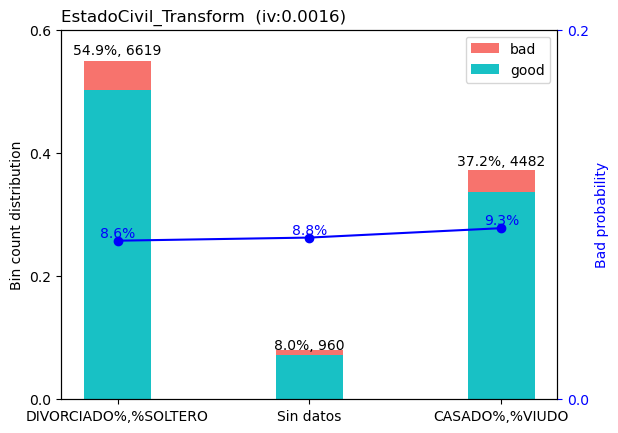

In [45]:
calcular_iv('EstadoCivil_Transform',df=df)

In [46]:
dict_Estado_Civil = {
    'DIVORCIADO': 1,
    'SOLTERO': 1,
    'Sin datos': 2,
    'CASADO': 3,
    'VIUDO': 3
}

In [47]:
df['EstadoCivil_cat'] = df['EstadoCivil_Transform'].replace(dict_Estado_Civil)

df['EstadoCivil_cat'].value_counts()

EstadoCivil_cat
1    6619
3    4482
2     960
Name: count, dtype: int64

#### 2.1.7. Grado Académico

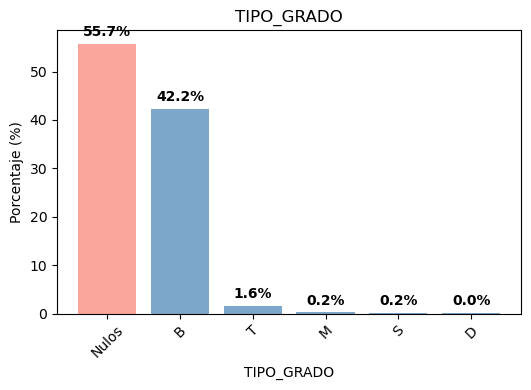

In [48]:
grafico_barras(['TIPO_GRADO'])

Se descarta variable por exceso de nulos

#### 2.1.8. TEA

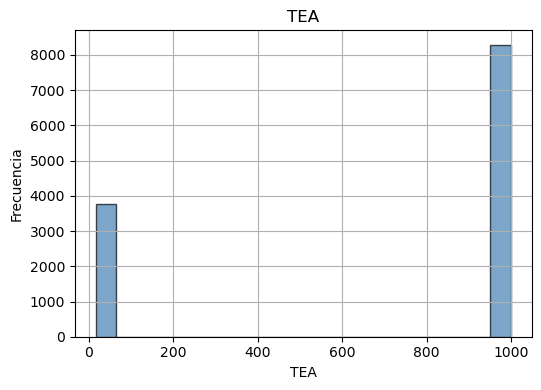

In [49]:
grafico_histogramas(['TEA'])

In [50]:
df['TEA'].value_counts()

TEA
999.00    8285
29.99     1367
34.96     1106
25.34      451
18.44      380
22.56      277
15.53      124
20.98       71
Name: count, dtype: int64

In [51]:
df['TEA'].isnull().sum()

0

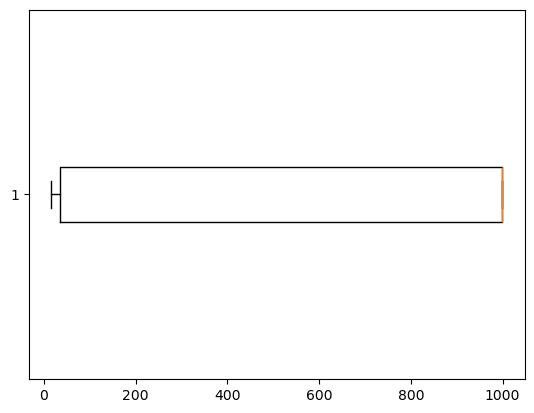

In [52]:
plt.boxplot(df['TEA'],vert=False)
plt.show()

##### Transformación Logarítimica

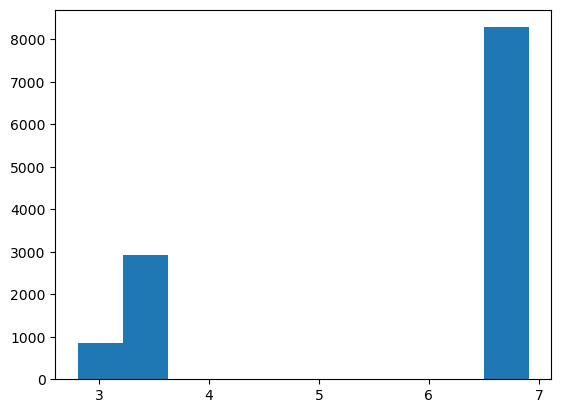

In [53]:
df['TEA_log'] = np.log1p(df['TEA'])

plt.hist(df['TEA_log'])
plt.show()

#### 2.1.9. Segmento Consumo

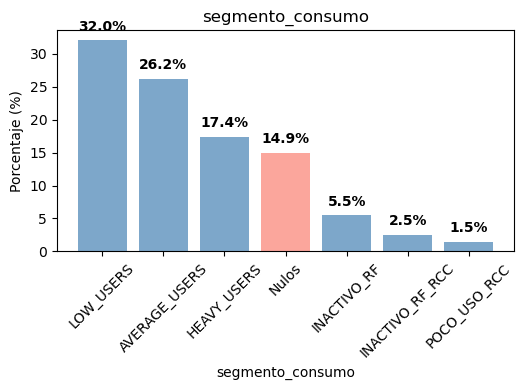

In [54]:
grafico_barras(['segmento_consumo'])

Por el elevado nivel de valores nulos, se descarta esta variable

#### 2.1.10. Situación Laboral

In [55]:
# Seleccionar la situación laboral de los últimos 5 meses
cols_situacion_laboral = ['SIT_LABORAL_t_2','SIT_LABORAL_t_3','SIT_LABORAL_t_4','SIT_LABORAL_t_5']

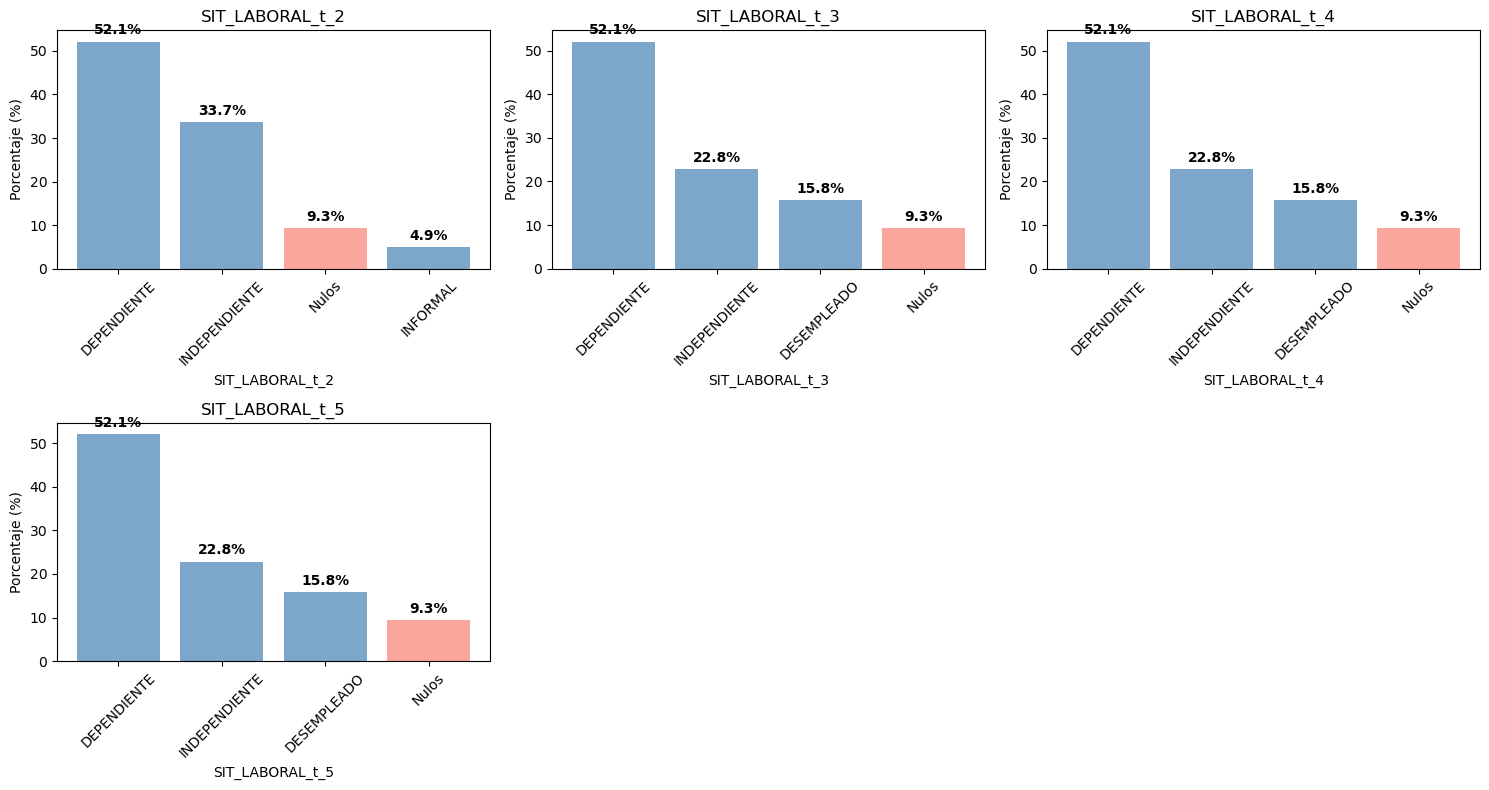

In [56]:
grafico_barras(cols_situacion_laboral)

In [57]:
df[cols_situacion_laboral] = df[cols_situacion_laboral].fillna('Sin datos')

[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...


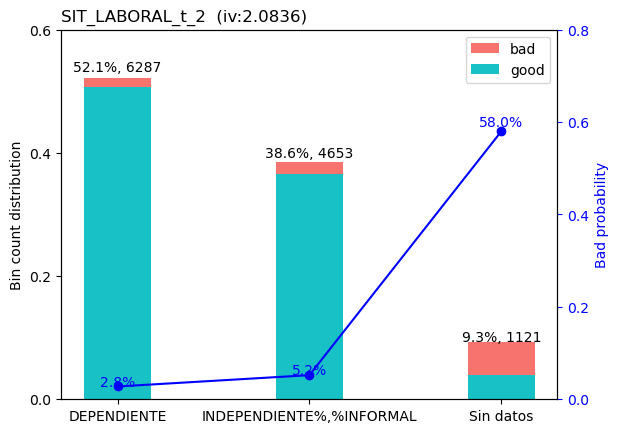

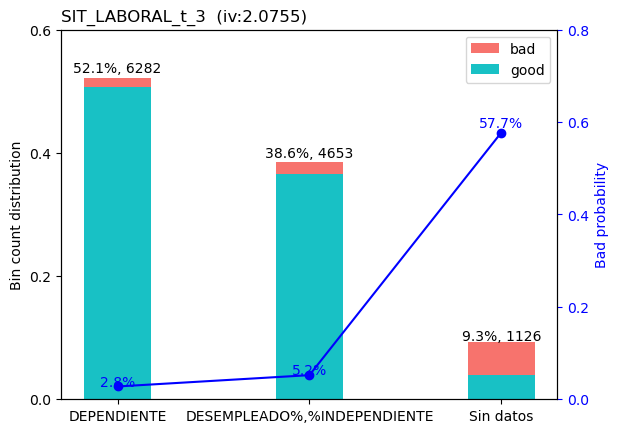

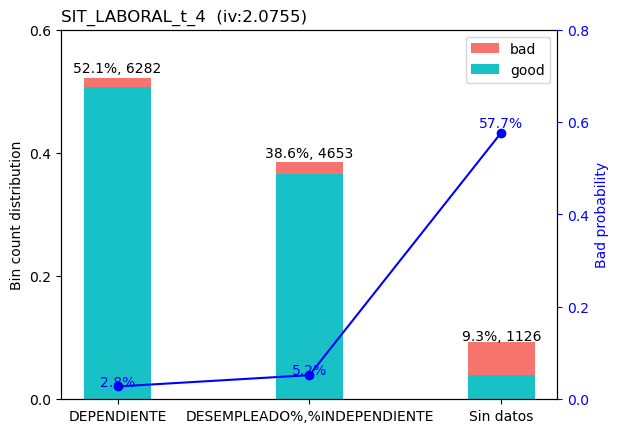

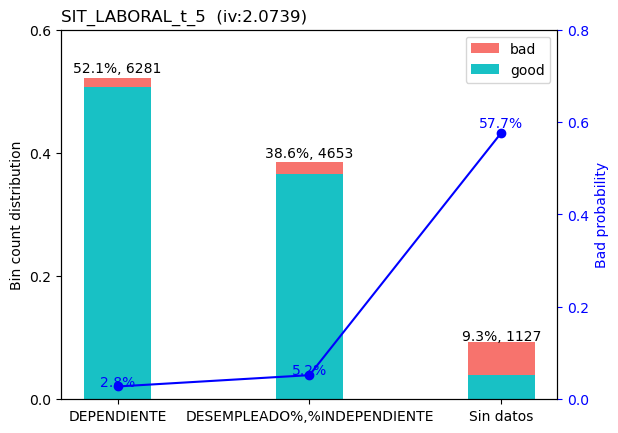

In [58]:
for col in cols_situacion_laboral:
    binning = sc.woebin(df, y='incumplio_pago', x=col)
    sc.woebin_plot(binning)

En el análisis de WOE e I Value observamos lo siguiente:

1. Los clientes en estado dependiente tienen una **menor probabilidad de incumplir el pago** (2.6%), lo cual se puede explicar por la estabilidad y los ingresos fijos.
2. Los clientes en estado desempleado, informal e independientes tienen **casi el doble de probabilidad de incumplir el pago** (5.1%). El análisis WOE los agrupa debido a que tienen un WOE similar.
3. Los clientes que no tienen datos, <u><strong>tienen un riesgo muy elevado</strong></u>, de casi un 57.4%
4. La capacidad predictiva de esta variable (I Value) es de **2.07** aproximadamente, lo que habla de una capacidad de predicción bastante alta.

In [59]:
dict_bin_sit_laboral = {
    'DEPENDIENTE': 3,
    'DESEMPLEADO': 2,
    'INDEPENDIENTE': 2,
    'INFORMAL': 2,
    'Sin datos': 1
}

In [60]:
df[cols_situacion_laboral] = df[cols_situacion_laboral].replace(dict_bin_sit_laboral)

df[cols_situacion_laboral].head()

,SIT_LABORAL_t_2,SIT_LABORAL_t_3,SIT_LABORAL_t_4,SIT_LABORAL_t_5
0,3,3,3,3
1,3,3,3,3
2,2,2,2,2
3,3,3,3,3
4,3,3,3,3


##### Análisis Factorial

In [61]:
cols_situacion_laboral

['SIT_LABORAL_t_2', 'SIT_LABORAL_t_3', 'SIT_LABORAL_t_4', 'SIT_LABORAL_t_5']

In [62]:
test_esfericidad_bartlett(df,cols=cols_situacion_laboral)

Bartlett’s Test:
  Chi-square: nan    p-value: nan

KMO Test:
  KMO global: 0.6662305385788592


In [63]:
# Columnas con varianza 0
print(df[cols_situacion_laboral].nunique())

# Correlación perfecta (1.0 o -1.0)
corr = df[cols_situacion_laboral].corr()
print(corr)

SIT_LABORAL_t_2    3
SIT_LABORAL_t_3    3
SIT_LABORAL_t_4    3
SIT_LABORAL_t_5    3
dtype: int64
                 SIT_LABORAL_t_2  SIT_LABORAL_t_3  SIT_LABORAL_t_4  \
SIT_LABORAL_t_2         1.000000         0.998078         0.998078   
SIT_LABORAL_t_3         0.998078         1.000000         1.000000   
SIT_LABORAL_t_4         0.998078         1.000000         1.000000   
SIT_LABORAL_t_5         0.997694         0.999616         0.999616   

                 SIT_LABORAL_t_5  
SIT_LABORAL_t_2         0.997694  
SIT_LABORAL_t_3         0.999616  
SIT_LABORAL_t_4         0.999616  
SIT_LABORAL_t_5         1.000000  


Se puede ver una correlación perfecta entre la situación laboral del mes t_3 y el mes t_4. Esto va a generar un problema a la hora de aplicar en análisis factorial, así que optaremos por eliminar una.

In [64]:
df_cols_situacion_laboral = eliminar_corr_perfecta(df[cols_situacion_laboral])
df_cols_situacion_laboral

,SIT_LABORAL_t_2,SIT_LABORAL_t_3,SIT_LABORAL_t_5
0,3,3,3
1,3,3,3
2,2,2,2
3,3,3,3
4,3,3,3
...,...,...,...
12056,1,1,1
12057,1,1,1
12058,1,1,1
12059,2,2,2


In [65]:
def generar_analisis_factorial(dataframe: pd.DataFrame, rotation=None):

    # Llamar al análisis Factorial
    fa = FactorAnalyzer(rotation=rotation)  # primero sin rotación

    fa.fit(dataframe)

    # Extraemos eigenvalues y explicamos su significado
    ev, v = fa.get_eigenvalues()
    # ev = eigenvalues
    # v  = varianza explicada acumulada (no confundir con PCA; es un método de FA)
    
    # Graficamos un scree plot de los eigenvalues
    plt.figure(figsize=(6,4))
    plt.plot(range(1, dataframe.shape[1] + 1), ev, marker='o')
    plt.title('Scree Plot - Análisis Factorial')
    plt.xlabel('Número de factores')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1, color='r', linestyle='--')  # guía habitual
    plt.show()

    print("Eigenvalues de cada factor:", ev)
    # Un criterio clásico (Kaiser) sugiere quedarnos con los factores
    # cuyos eigenvalues sean > 1. Sin embargo, también se pueden usar
    # otras heurísticas (ej. codo, varianza total deseada, etc.)
    
    # Como ejemplo, supongamos que elegimos 2 factores (observando la gráfica
    # o guiándonos por eigenvalue > 1).

In [66]:
def generar_cargas_factoriales(dataframe: pd.DataFrame, nom_factor: str,num_factores=1, rotation='varimax'):
    # Llamar al análisis Factorial
    fa = FactorAnalyzer(n_factors=num_factores, rotation=rotation)

    # Entrenar Dataframe
    fa.fit(dataframe)

    # Obtenemos las cargas factoriales (factor loadings)
    cargas = fa.loadings_

    # Extraer eigenvalues y varianza explicada
    ev, v = fa.get_eigenvalues()

    # Generar columnas para los factores
    columnas = [f"Factor_{i+1}_{nom_factor}" for i in range(num_factores)]

    # Tabla de cargas factoriales
    tabla_cargas = pd.DataFrame(cargas, index=dataframe.columns, columns=columnas)

    print("\nCargas Factoriales:")
    display(tabla_cargas)

    # Transformar datos a factores
    df_factores = fa.transform(dataframe)

    # Crear DataFrame con los factores
    df_factores = pd.DataFrame(df_factores, columns=columnas)

    print(f"\nPrimeras 5 filas de los {num_factores} factores:")
    display(df_factores.head())

    return df_factores

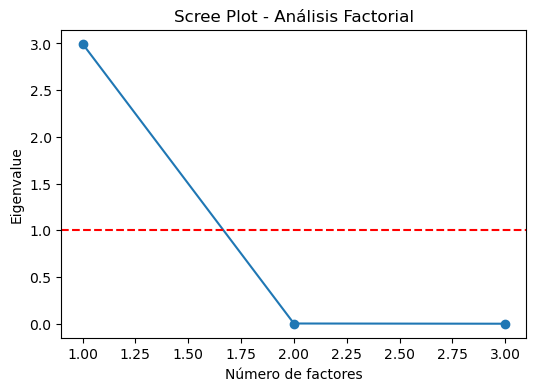

Eigenvalues de cada factor: [2.99692543e+00 2.71145685e-03 3.63111639e-04]


In [67]:
generar_analisis_factorial(df_cols_situacion_laboral)

Se puede concluir del análisis lo siguiente:
- Los resultados de los tests indican que las columnas son aptas para que se les aplique el Análisis Factorial
- El único eigenvalue mayor a 1 es el primer factor, así que el número de factores a utilizar será 1

In [68]:
# Multiplicamos por menos 1 para mejorar la interpretabilidad
factor_sit_laboral = generar_cargas_factoriales(df_cols_situacion_laboral, 'SIT_LAB', num_factores=1, rotation='varimax') * -1
factor_sit_laboral


Cargas Factoriales:


,Factor_1_SIT_LAB
SIT_LABORAL_t_2,-0.998269
SIT_LABORAL_t_3,-0.998910
SIT_LABORAL_t_5,-0.998782



Primeras 5 filas de los 1 factores:


,Factor_1_SIT_LAB
0,-0.871159
1,-0.871159
2,0.651087
3,-0.871159
4,-0.871159


,Factor_1_SIT_LAB
0,0.871159
1,0.871159
2,-0.651087
3,0.871159
4,0.871159
...,...
12056,-2.173334
12057,-2.173334
12058,-2.173334
12059,-0.651087


In [69]:
# Concatenar a DataFrame original
df = pd.concat([df.reset_index(drop=True), factor_sit_laboral.reset_index(drop=True)], axis=1)
df.head()

,ID,PERIODO,Generacion,SIT_LABORAL_t_6,SIT_LABORAL_t_5,SIT_LABORAL_t_4,SIT_LABORAL_t_3,SIT_LABORAL_t_2,SIT_LABORAL_t_1,SIT_LABORAL_t,...,macrorisk_num,SEGMENTO_MERCADO_num,Edad_transform,Sexo_M,Sexo_F,Sexo_Sin_Datos,EstadoCivil_Transform,EstadoCivil_cat,TEA_log,Factor_1_SIT_LAB
0,1,202109,4. Baby Boomers,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,1.0,3.0,56.0,1,0,0,Sin datos,2,6.907755,0.871159
1,2,202109,3. Generación X,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,1.0,1.0,44.0,0,1,0,SOLTERO,1,6.907755,0.871159
2,3,202109,3. Generación X,INDEPENDIENTE,2,2,2,2,INDEPENDIENTE,INDEPENDIENTE,...,1.0,2.0,42.0,1,0,0,CASADO,3,6.907755,-0.651087
3,4,202109,5. Silent Generation,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,1.0,3.0,66.0,1,0,0,CASADO,3,6.907755,0.871159
4,5,202109,3. Generación X,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,1.0,3.0,43.0,1,0,0,SOLTERO,1,6.907755,0.871159


#### 2.1.11. Rango de Ratio de Uso Linea

In [70]:
cols_rango_endeudamiento = ['RNG_RAT_USO_LINEA_RCC_t_2',
                            'RNG_RAT_USO_LINEA_RCC_t_3',
                            'RNG_RAT_USO_LINEA_RCC_t_4',
                            'RNG_RAT_USO_LINEA_RCC_t_5']

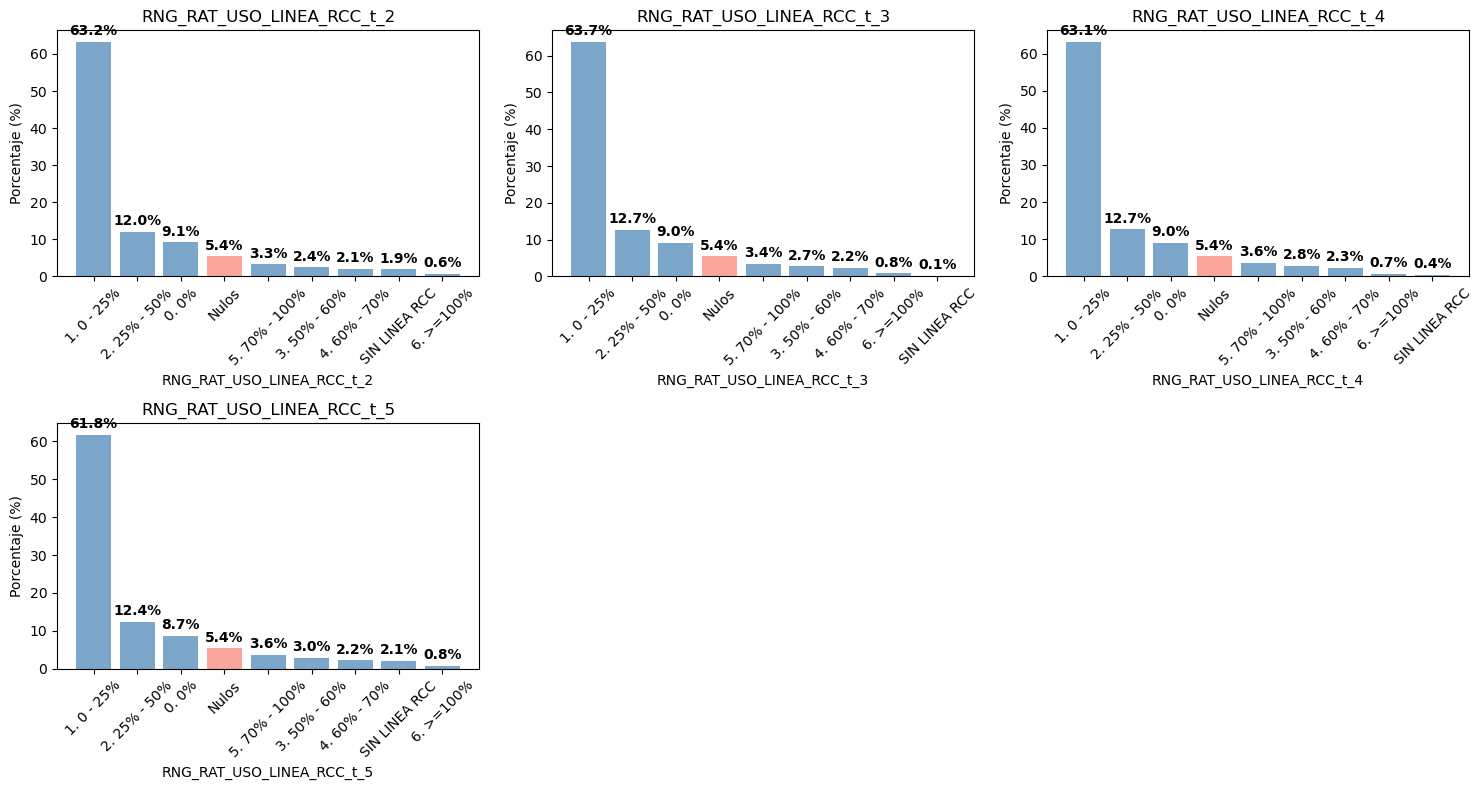

In [71]:
grafico_barras(cols_rango_endeudamiento)

In [72]:
df[cols_rango_endeudamiento] = df[cols_rango_endeudamiento].fillna('Sin datos')

[INFO] creating woe binning ...
                    variable  \
0  RNG_RAT_USO_LINEA_RCC_t_2   
1  RNG_RAT_USO_LINEA_RCC_t_2   
2  RNG_RAT_USO_LINEA_RCC_t_2   

                                                 bin  count  count_distr  \
0                         SIN LINEA RCC%,%1. 0 - 25%   7854     0.651190   
1  2. 25% - 50%%,%0. 0%%,%3. 50% - 60%%,%4. 60% -...   3480     0.288533   
2                              6. >=100%%,%Sin datos    727     0.060277   

   good  bad   badprob       woe    bin_iv  total_iv  \
0  7719  135  0.017189 -1.713667  0.986365  4.186998   
1  3229  251  0.072126 -0.221976  0.012978  4.186998   
2    46  681  0.936726  5.027420  3.187655  4.186998   

                                              breaks  is_special_values  
0                         SIN LINEA RCC%,%1. 0 - 25%              False  
1  2. 25% - 50%%,%0. 0%%,%3. 50% - 60%%,%4. 60% -...              False  
2                              6. >=100%%,%Sin datos              False  

IV de la col

<Figure size 1600x600 with 0 Axes>

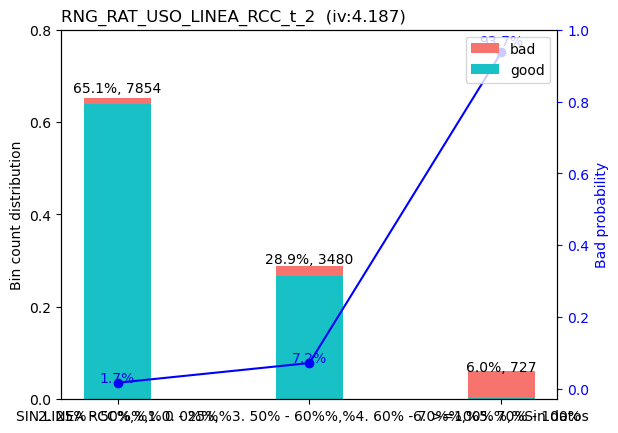

[INFO] creating woe binning ...
                    variable  \
0  RNG_RAT_USO_LINEA_RCC_t_3   
1  RNG_RAT_USO_LINEA_RCC_t_3   
2  RNG_RAT_USO_LINEA_RCC_t_3   
3  RNG_RAT_USO_LINEA_RCC_t_3   

                                                 bin  count  count_distr  \
0                         SIN LINEA RCC%,%1. 0 - 25%   7698     0.638256   
1                                       2. 25% - 50%   1528     0.126689   
2  0. 0%%,%3. 50% - 60%%,%4. 60% - 70%%,%5. 70% -...   2093     0.173535   
3                              6. >=100%%,%Sin datos    742     0.061521   

   good  bad   badprob       woe    bin_iv  total_iv  \
0  7573  125  0.016238 -1.771532  1.012748  4.090848   
1  1471   57  0.037304 -0.918148  0.073800  4.090848   
2  1889  204  0.097468  0.106816  0.002069  4.090848   
3    61  681  0.917790  4.745187  3.002230  4.090848   

                                              breaks  is_special_values  
0                         SIN LINEA RCC%,%1. 0 - 25%              False

<Figure size 1600x600 with 0 Axes>

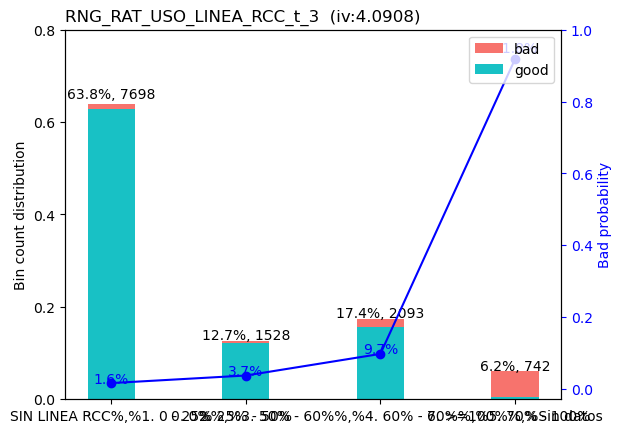

[INFO] creating woe binning ...
                    variable                                  bin  count  \
0  RNG_RAT_USO_LINEA_RCC_t_4           SIN LINEA RCC%,%1. 0 - 25%   7662   
1  RNG_RAT_USO_LINEA_RCC_t_4  2. 25% - 50%%,%0. 0%%,%3. 50% - 60%   2946   
2  RNG_RAT_USO_LINEA_RCC_t_4         4. 60% - 70%%,%5. 70% - 100%    713   
3  RNG_RAT_USO_LINEA_RCC_t_4                6. >=100%%,%Sin datos    740   

   count_distr  good  bad   badprob       woe    bin_iv  total_iv  \
0     0.635271  7543  119  0.015531 -1.816753  1.043859  4.192629   
1     0.244258  2797  149  0.050577 -0.599858  0.068844  4.192629   
2     0.059116   596  117  0.164095  0.704432  0.039055  4.192629   
3     0.061355    58  682  0.921622  4.797085  3.040871  4.192629   

                                breaks  is_special_values  
0           SIN LINEA RCC%,%1. 0 - 25%              False  
1  2. 25% - 50%%,%0. 0%%,%3. 50% - 60%              False  
2         4. 60% - 70%%,%5. 70% - 100%              False  
3

<Figure size 1600x600 with 0 Axes>

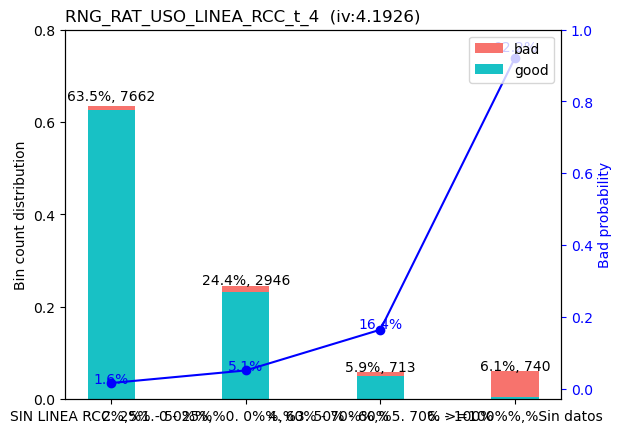

[INFO] creating woe binning ...
                    variable  \
0  RNG_RAT_USO_LINEA_RCC_t_5   
1  RNG_RAT_USO_LINEA_RCC_t_5   
2  RNG_RAT_USO_LINEA_RCC_t_5   

                                                 bin  count  count_distr  \
0                         SIN LINEA RCC%,%1. 0 - 25%   7705     0.638836   
1  2. 25% - 50%%,%0. 0%%,%3. 50% - 60%%,%4. 60% -...   3609     0.299229   
2                              6. >=100%%,%Sin datos    747     0.061935   

   good  bad   badprob       woe    bin_iv  total_iv  \
0  7574  131  0.017002 -1.724781  0.976480  4.129727   
1  3365  244  0.067609 -0.291516  0.022563  4.129727   
2    55  692  0.926372  4.864751  3.130685  4.129727   

                                              breaks  is_special_values  
0                         SIN LINEA RCC%,%1. 0 - 25%              False  
1  2. 25% - 50%%,%0. 0%%,%3. 50% - 60%%,%4. 60% -...              False  
2                              6. >=100%%,%Sin datos              False  

IV de la col

<Figure size 1600x600 with 0 Axes>

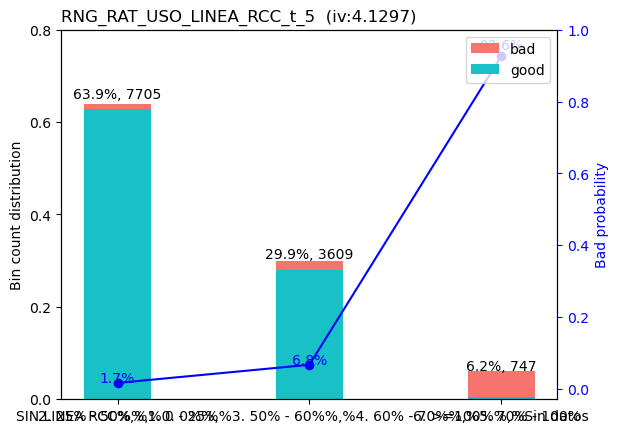

In [73]:
for col in cols_rango_endeudamiento:
    calcular_iv(col,df=df)

In [74]:
dict_rango_endeudamiento = {
    'SIN LINEA RCC': 3,
    '0. 0%': 3,
    '1. 0 - 25%': 3,
    '2. 25% - 50%': 2,
    '3. 50% - 60%': 2,
    '4. 60% - 70%': 2,
    '5. 70% - 100%': 2,
    '6. >=100%': 1,
    'Sin datos': 1
}

In [75]:
df['rango_endeudamiento_num_t_2'] = df['RNG_RAT_USO_LINEA_RCC_t_2'].replace(dict_rango_endeudamiento)
df['rango_endeudamiento_num_t_3'] = df['RNG_RAT_USO_LINEA_RCC_t_3'].replace(dict_rango_endeudamiento)
df['rango_endeudamiento_num_t_4'] = df['RNG_RAT_USO_LINEA_RCC_t_4'].replace(dict_rango_endeudamiento)
df['rango_endeudamiento_num_t_5'] = df['RNG_RAT_USO_LINEA_RCC_t_5'].replace(dict_rango_endeudamiento)
#df['rango_endeudamiento_num_t_6'] = df['RNG_RAT_USO_LINEA_RCC_t_6'].replace(dict_rango_endeudamiento)

In [76]:
cols_rango_endeudamiento_num = [col for col in df.columns if col.startswith('rango_endeudamiento_num')]

cols_rango_endeudamiento_num

['rango_endeudamiento_num_t_2',
 'rango_endeudamiento_num_t_3',
 'rango_endeudamiento_num_t_4',
 'rango_endeudamiento_num_t_5']

[INFO] creating woe binning ...
                      variable         bin  count  count_distr  good  bad  \
0  rango_endeudamiento_num_t_2  [-inf,2.0)    727     0.060277    46  681   
1  rango_endeudamiento_num_t_2   [2.0,3.0)   2378     0.197164  2194  184   
2  rango_endeudamiento_num_t_2   [3.0,inf)   8956     0.742559  8754  202   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.936726  5.027420  3.187655   4.06348    2.0              False  
1  0.077376 -0.146047  0.003960   4.06348    3.0              False  
2  0.022555 -1.436500  0.871864   4.06348    inf              False  

IV de la columna rango_endeudamiento_num_t_2: 4.063479951595842


<Figure size 1600x600 with 0 Axes>

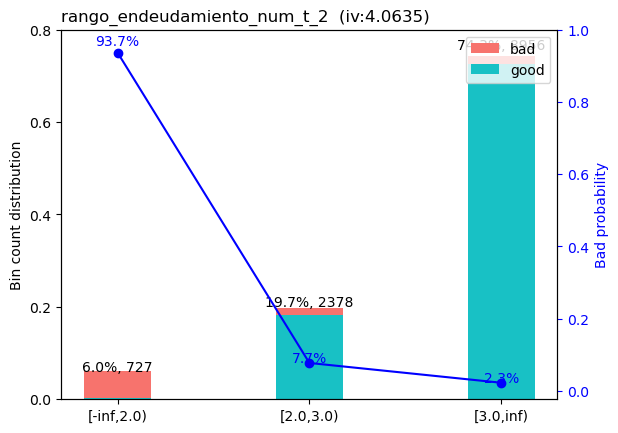

[INFO] creating woe binning ...
                      variable         bin  count  count_distr  good  bad  \
0  rango_endeudamiento_num_t_3  [-inf,2.0)    742     0.061521    61  681   
1  rango_endeudamiento_num_t_3   [2.0,3.0)   2533     0.210016  2339  194   
2  rango_endeudamiento_num_t_3   [3.0,inf)   8786     0.728464  8594  192   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.917790  4.745187  3.002230  3.890964    2.0              False  
1  0.076589 -0.157122  0.004860  3.890964    3.0              False  
2  0.021853 -1.468825  0.883874  3.890964    inf              False  

IV de la columna rango_endeudamiento_num_t_3: 3.8909644406643946


<Figure size 1600x600 with 0 Axes>

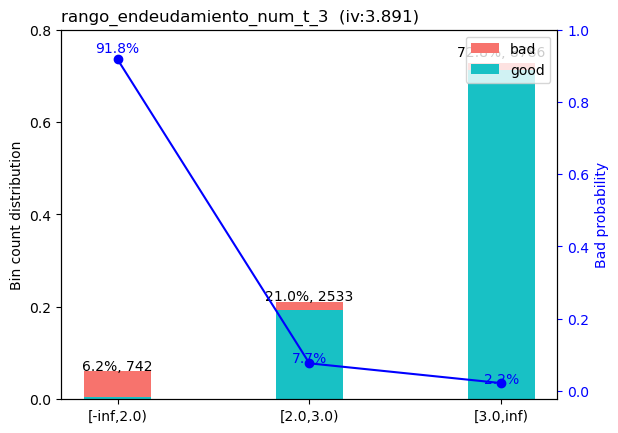

[INFO] creating woe binning ...
                      variable         bin  count  count_distr  good  bad  \
0  rango_endeudamiento_num_t_4  [-inf,2.0)    740     0.061355    58  682   
1  rango_endeudamiento_num_t_4   [2.0,3.0)   2575     0.213498  2372  203   
2  rango_endeudamiento_num_t_4   [3.0,inf)   8746     0.725147  8564  182   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.921622  4.797085  3.040871  3.968125    2.0              False  
1  0.078835 -0.125784  0.003208  3.968125    3.0              False  
2  0.020810 -1.518817  0.924046  3.968125    inf              False  

IV de la columna rango_endeudamiento_num_t_4: 3.9681247303247673


<Figure size 1600x600 with 0 Axes>

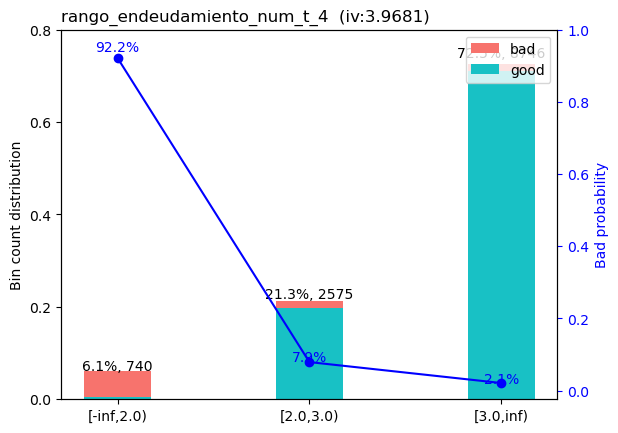

[INFO] creating woe binning ...
                      variable         bin  count  count_distr  good  bad  \
0  rango_endeudamiento_num_t_5  [-inf,2.0)    747     0.061935    55  692   
1  rango_endeudamiento_num_t_5   [2.0,3.0)   2555     0.211840  2360  195   
2  rango_endeudamiento_num_t_5   [3.0,inf)   8759     0.726225  8579  180   

    badprob       woe    bin_iv  total_iv breaks  is_special_values  
0  0.926372  4.864751  3.130685  4.072613    2.0              False  
1  0.076321 -0.160919  0.005134  4.072613    3.0              False  
2  0.020550 -1.531617  0.936794  4.072613    inf              False  

IV de la columna rango_endeudamiento_num_t_5: 4.072613357751966


<Figure size 1600x600 with 0 Axes>

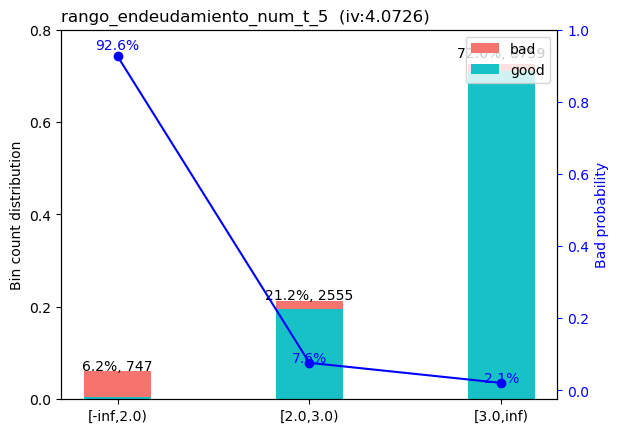

In [77]:
# Revisamos el nivel de Endeudamiento ya categorizado
for col in cols_rango_endeudamiento_num:
    calcular_iv(col,df=df)

#### Análisis Factorial

In [78]:
test_esfericidad_bartlett(dataframe=df,cols=cols_rango_endeudamiento_num)

Bartlett’s Test:
  Chi-square: 58971.46377877566    p-value: 0.0

KMO Test:
  KMO global: 0.8584439952995229


In [79]:
df_rango_endeudamiento_num = eliminar_corr_perfecta(df[cols_rango_endeudamiento_num])
df_rango_endeudamiento_num

,rango_endeudamiento_num_t_2,rango_endeudamiento_num_t_3,rango_endeudamiento_num_t_4,rango_endeudamiento_num_t_5
0,3,3,3,3
1,2,2,2,2
2,3,3,3,3
3,3,3,3,3
4,3,3,2,2
...,...,...,...,...
12056,3,3,3,3
12057,3,3,3,3
12058,3,3,3,3
12059,3,2,3,3


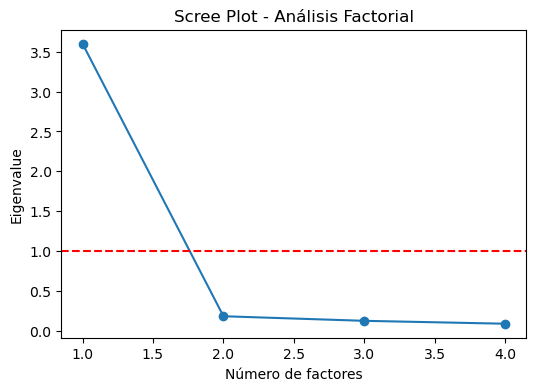

Eigenvalues de cada factor: [3.59999665 0.18372455 0.12631779 0.08996101]


In [80]:
generar_analisis_factorial(df_rango_endeudamiento_num)

In [81]:
factor_rango_endeudamiento = generar_cargas_factoriales(df_rango_endeudamiento_num,'RNG_END',num_factores=1,rotation='varimax')


Cargas Factoriales:


,Factor_1_RNG_END
rango_endeudamiento_num_t_2,-0.920829
rango_endeudamiento_num_t_3,-0.946810
rango_endeudamiento_num_t_4,-0.946922
rango_endeudamiento_num_t_5,-0.909233



Primeras 5 filas de los 1 factores:


,Factor_1_RNG_END
0,-0.583155
1,1.176618
2,-0.583155
3,-0.583155
4,0.277244


In [82]:
# Concatenar a DataFrame original
df = pd.concat([df.reset_index(drop=True), factor_rango_endeudamiento.reset_index(drop=True)], axis=1)
df.head()

,ID,PERIODO,Generacion,SIT_LABORAL_t_6,SIT_LABORAL_t_5,SIT_LABORAL_t_4,SIT_LABORAL_t_3,SIT_LABORAL_t_2,SIT_LABORAL_t_1,SIT_LABORAL_t,...,Sexo_Sin_Datos,EstadoCivil_Transform,EstadoCivil_cat,TEA_log,Factor_1_SIT_LAB,rango_endeudamiento_num_t_2,rango_endeudamiento_num_t_3,rango_endeudamiento_num_t_4,rango_endeudamiento_num_t_5,Factor_1_RNG_END
0,1,202109,4. Baby Boomers,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,0,Sin datos,2,6.907755,0.871159,3,3,3,3,-0.583155
1,2,202109,3. Generación X,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,0,SOLTERO,1,6.907755,0.871159,2,2,2,2,1.176618
2,3,202109,3. Generación X,INDEPENDIENTE,2,2,2,2,INDEPENDIENTE,INDEPENDIENTE,...,0,CASADO,3,6.907755,-0.651087,3,3,3,3,-0.583155
3,4,202109,5. Silent Generation,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,0,CASADO,3,6.907755,0.871159,3,3,3,3,-0.583155
4,5,202109,3. Generación X,DEPENDIENTE,3,3,3,3,DEPENDIENTE,DEPENDIENTE,...,0,SOLTERO,1,6.907755,0.871159,3,3,2,2,0.277244


In [83]:
cols_logit = ['Edad_transform',
              'Sexo_M',
              'Sexo_F',
              'Sexo_Sin_Datos',
              'macrorisk_num',
              'SEGMENTO_MERCADO_num',
              'Factor_1_SIT_LAB',
              'Factor_1_RNG_END',
              'TEA_log']

df_logit = df[cols_logit + ['incumplio_pago']].dropna(how='any')

print('Total de Filas en DataFrame para Regresión Logística:',len(df_logit))
print('Total de Nulos en DataFrame:',df_logit.isnull().sum().sum())

Total de Filas en DataFrame para Regresión Logística: 12032
Total de Nulos en DataFrame: 0


### 2.2. Análisis Multivariado

#### 2.2.1. Matriz de Correlación

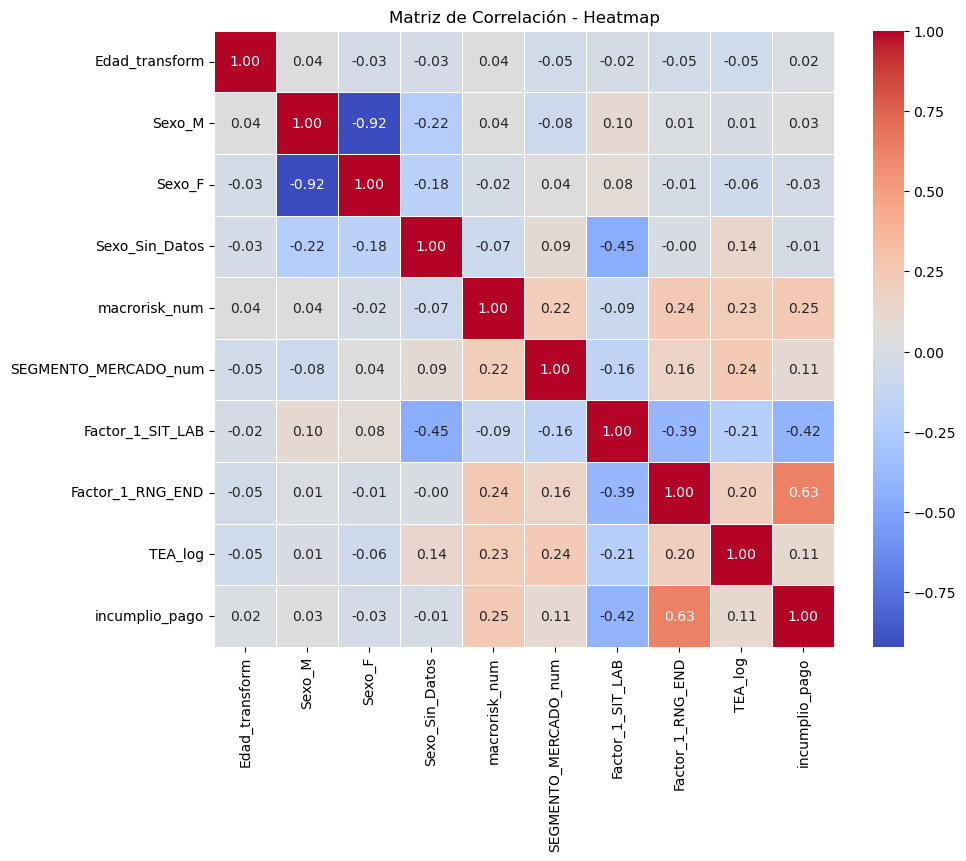

In [84]:
corr_matrix = df_logit.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10,8))

# Crear el heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación - Heatmap")
plt.show()

In [85]:
cols_logit_final = [
                    #'Edad_transform',
                    'Sexo_M',
                    'Sexo_F',
                    #'EstadoCivil_Casado',
                    #'EstadoCivil_cat',
                    #'EstadoCivil_Divorciado',
                    #'EstadoCivil_Viudo',
                    'macrorisk_num',
                    #'SEGMENTO_MERCADO_num',
                    #'TEA_log',
                    'Factor_1_RNG_END',
                    'Factor_1_SIT_LAB',
                    'incumplio_pago']

### 2.2.2. Análisis de VIF

In [86]:
# Validar Multicolinealidad usando VIF
X = df_logit[cols_logit_final].drop(columns=['incumplio_pago'])
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

           Variable       VIF
0            Sexo_M  2.605560
1            Sexo_F  2.259551
2     macrorisk_num  3.885433
3  Factor_1_RNG_END  1.217509
4  Factor_1_SIT_LAB  1.228844


## 3. Entrenamiento del Modelo

### 3.1. Escalamiento de Variables Continuas

### 3.2. Balanceo de Datos

In [87]:
df_logit_final = df_logit[cols_logit_final]

In [88]:
from imblearn.over_sampling import SMOTE

# 1️⃣ Separar en Train/Test (antes de aplicar SMOTE)
X = df_logit_final.drop(columns=['incumplio_pago'])
y = df_logit_final['incumplio_pago']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2️⃣ Aplicar SMOTE solo al Train
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### 3.3. Resultados del Modelo

In [89]:
# 3️⃣ Ajustar modelo con statsmodels en Train resampleado
X_train_resampled_sm = sm.add_constant(X_train_resampled)
modelo = sm.Logit(y_train_resampled, X_train_resampled_sm).fit()
print(modelo.summary())

# 4️⃣ Predecir sobre Test set original
X_test_sm = sm.add_constant(X_test)
y_pred_prob = modelo.predict(X_test_sm)
y_pred = (y_pred_prob >= 0.5).astype(int)

# 5️⃣ Métricas de evaluación
print("\n📊 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ Recall: {recall_score(y_test, y_pred):.4f}")
print(f"✅ Precision: {precision_score(y_test, y_pred):.4f}")
print(f"✅ AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")

Optimization terminated successfully.
         Current function value: 0.340898
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         incumplio_pago   No. Observations:                17544
Model:                          Logit   Df Residuals:                    17538
Method:                           MLE   Df Model:                            5
Date:                Thu, 17 Apr 2025   Pseudo R-squ.:                  0.5082
Time:                        16:09:07   Log-Likelihood:                -5980.7
converged:                       True   LL-Null:                       -12161.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.1605      0.131    -31.671      0.000      -4.418      -3.903
Sexo_M     

### 3.4. K-Fold Cross Validation

In [90]:
# Inicializar KFold (estratificado)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Para almacenar resultados
accuracy_list, recall_list, precision_list, auc_list = [], [], [], []

for train_idx, test_idx in kf.split(X, y):
    # Separar train/test para este fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # SMOTE solo en train
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Ajustar modelo con statsmodels
    X_train_sm = sm.add_constant(X_train_res)
    model = sm.Logit(y_train_res, X_train_sm).fit(disp=False)

    # Predecir en test
    X_test_sm = sm.add_constant(X_test)
    y_prob = model.predict(X_test_sm)
    y_pred = (y_prob >= 0.5).astype(int)

    # Métricas
    accuracy_list.append(accuracy_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_prob))

# Promedio y desvío
print(f"\n✅ Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"✅ Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
print(f"✅ Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
print(f"✅ AUC-ROC: {np.mean(auc_list):.4f} ± {np.std(auc_list):.4f}")


✅ Accuracy: 0.8823 ± 0.0060
✅ Recall: 0.8171 ± 0.0184
✅ Precision: 0.4170 ± 0.0133
✅ AUC-ROC: 0.9185 ± 0.0035


In [91]:
coef_dict = modelo.params.to_dict()

coef_dict

{'const': -4.16046858588387,
 'Sexo_M': 1.9526275169810228,
 'Sexo_F': 1.7068582934752858,
 'macrorisk_num': 0.8434110347540852,
 'Factor_1_RNG_END': 1.0597196273578897,
 'Factor_1_SIT_LAB': -0.6707264147706867}

In [92]:
df_logit_final.head()

,Sexo_M,Sexo_F,macrorisk_num,Factor_1_RNG_END,Factor_1_SIT_LAB,incumplio_pago
0,1,0,1.0,-0.583155,0.871159,0
1,0,1,1.0,1.176618,0.871159,0
2,1,0,1.0,-0.583155,-0.651087,0
3,1,0,1.0,-0.583155,0.871159,0
4,1,0,1.0,0.277244,0.871159,0


In [93]:
def calcular_probabilidad_fila(row, coef_dict):
    # Verifica si hay nulos
    for var in coef_dict.keys():
        if var != 'const' and (var not in row or pd.isnull(row[var])):
            return 0
        
    # Calcular logit (z)
    z = coef_dict['const']
    for var, coef in coef_dict.items():
        if var != 'const':
            z += coef * row[var]

    # Probabilidad logística
    prob = 1 / (1 + np.exp(-z))
    return 1 - prob

In [94]:
df_logit_final.head()

,Sexo_M,Sexo_F,macrorisk_num,Factor_1_RNG_END,Factor_1_SIT_LAB,incumplio_pago
0,1,0,1.0,-0.583155,0.871159,0
1,0,1,1.0,1.176618,0.871159,0
2,1,0,1.0,-0.583155,-0.651087,0
3,1,0,1.0,-0.583155,0.871159,0
4,1,0,1.0,0.277244,0.871159,0


In [95]:
df_final = df.copy()

df['prob_incumplimiento'] = df.apply(lambda row: calcular_probabilidad_fila(row, coef_dict), axis=1)


In [96]:
df_final = df.copy()

df_final['prob_incumplimiento'] = df_final.apply(lambda row: calcular_probabilidad_fila(row, coef_dict), axis=1)
df_final['VALOR_CARTERA'] = df_final['TOTAL_DEUDA'] * df_final['prob_incumplimiento']

df_final[['ID'] + cols_logit_final + ['TOTAL_DEUDA','prob_incumplimiento','VALOR_CARTERA']].to_excel('PRUEBA_1.xlsx')

## 4. Conclusiones y Recomendaciones

Para la probabilidad de incumplimiento de pago del cliente, se obtuvo la siguiente fórmula de regresión logística se explican a través de la siguiente fórmula:

$\Huge
p = \frac{1}{1 + e^{-\left(-4.1266 + 1.9246 X_{\text{M}} + 1.6867 X_{\text{F}} + 0.8255 X_{\text{risk}} + 1.0829 X_{\text{RNG}} + 0.6576 X_{\text{SIT}} \right)}}
$

Donde: 
- $X_{\text{M}}$ = Indicador de sexo masculino
- $X_{\text{F}}$ = Indicador de sexo femenino
- $X_{\text{risk}}$ = Riesgo macroeconómico
- $X_{\text{RNG}}$ = Factor de endeudamiento
- $X_{\text{SIT}}$ = Factor de situación laboral

De los siguientes resultados, se concluye lo siguiente:
  
  - Si el cliente es hombre, tiene una probabilidad ligeramente más alta de incumplimiento en comparación a una cliente mujer.
  - Si el segmento macrorisk es más alto (más riesgoso), hay mayor probabilidad de incumplimiento.
  - Un valor más alto del segmento de mercado (P01, P02, etc.) aumenta la probabilidad de incumplimiento.
  - Un valor de TEA más alto aumenta la probabilidad de incumplimiento.
  - Mientras más alto el factor de Endeudamiento (más endeudado), mayor es la probabilidad de incumplimiento.
  - Finalmente, mientras más alto el factor de Situación Laboral (a mayor valor, mayor estabilidad laboral), menos es la probabilidad de incumplimiento.

## 5. Exportar Modelo a Pickle

In [98]:
with open('modelo_log_reg.pkl', 'wb') as archivo:
    print('Exportando modelo a archivo pickle')
    pickle.dump(modelo, archivo)

Exportando modelo a archivo pickle
